Downloads upperair sounding data from the University of Wyoming through siphon to plot a SkewT with hodograph along with computing variables and indices through MetPy.

In [18]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units, pandas_dataframe_to_unit_arrays
from metpy.plots import SkewT, Hodograph, add_metpy_logo
import metpy.calc as mpcalc
from siphon.simplewebservice.wyoming import WyomingUpperAir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [19]:
#set date and station
date = datetime(2020, 8, 10, 18)

station = input('Input station id:')
#station=input('Station id:')

df = WyomingUpperAir.request_data(date, station)


Input station id: ILX


In [20]:
print('initial data')
df

initial data


,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation
0,992.0,178,32.0,25.0,240.0,4.0,3.464102,2.000000,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
1,975.0,334,29.4,22.4,242.0,5.0,4.414738,2.347358,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
2,945.3,610,26.8,21.5,245.0,8.0,7.250462,3.380946,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
3,928.0,775,25.2,20.9,258.0,11.0,10.759624,2.287029,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
4,925.0,804,25.0,20.7,260.0,12.0,11.817693,2.083778,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,12.3,30170,-47.3,-82.3,108.0,37.0,-35.189091,11.433629,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
134,11.7,30480,-46.4,-81.4,110.0,39.0,-36.648012,13.338786,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
135,11.0,30912,-45.1,-80.1,99.0,35.0,-34.569092,5.475206,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0
136,10.7,31090,-43.7,-79.1,95.0,34.0,-33.870620,2.963295,ILX,74560,2020-08-10 18:00:00,40.15,-89.33,178.0


In [21]:
#add in appropiate units

data = pandas_dataframe_to_unit_arrays(df)
#print(data_with_units)

subset_to_100 = data['pressure'] >= 150 * units.hPa

# Subset pressure and read in other data to only 100 mb
p = data['pressure']
height = data['height']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']
deg = data['direction']
spd = data['speed']
#print(df.units)

In [22]:
#compute variables

#potential temp
pot = mpcalc.potential_temperature(p, T)

#relative humidity
rh = mpcalc.relative_humidity_from_dewpoint(T, Td)

#mixing ratio
mix = mpcalc.mixing_ratio_from_relative_humidity(rh, T, p)

#calculate path and levels from parcel

prof = (mpcalc.parcel_profile(p, T[0], Td[0])).to('degC')

#LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

#LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, which='top')

#EL
el_pressure, el_temperature = mpcalc.el(p, T, Td, which='top')

#SBCAPE and SBCIN
cape, cin = mpcalc.cape_cin(p, T, Td, prof)

#mixed layer CAPE
ML_cape, ML_cin = mpcalc.mixed_layer_cape_cin(p,T,Td)


#MUCAP and MUCIN
MU_cape, MU_cin = mpcalc.most_unstable_cape_cin(p, T, Td)

#precipitable water 
pwat = mpcalc.precipitable_water(Td, p).to('inches')

#bulk shear
bulk_shear = mpcalc.bulk_shear(p, u, v, heights=None, bottom=None, depth=None)

#bunkers storm motion
right_mover,left_mover,wind_mean = mpcalc.bunkers_storm_motion(p, u, v, height)

#helicity
pos_SRH,neg_SRH,total_SRH = mpcalc.storm_relative_helicity(u, v, height, 3000*units.meter, bottom=height[0], 
                                                           storm_u=right_mover[0], storm_v=right_mover[1])

                                    

c:\users\ebudd\opencv\lib\site-packages\metpy\calc\indices.py:52: FutureWarning: Input variables will be reordered in 1.0 to be (pressure, dewpt, bottom,top). To update to new input format before 1.0 is released, use`from metpy.future import precipitable_water`.
  warnings.warn('Input variables will be reordered in 1.0 to be (pressure, dewpt, bottom,'
c:\users\ebudd\opencv\lib\site-packages\metpy\calc\kinematics.py:580: FutureWarning: Input variables will be reordered in 1.0 to be (heights, u, v, depth, bottom, storm_u, storm_v). To update to new input format before 1.0 is released, use `from metpy.future import storm_relative_helicity`.
  warnings.warn('Input variables will be reordered in 1.0 to be (heights, u, v, depth, '


In [23]:
#calculate LI
def lifted_index(T,prof):
    '''this function calculates the lifted index.
    
       inputs:
       T = temperature
       prof = profile
       
       outputs: lifted_index'''
    
    tenv = T[np.where(p.m==500)]
    tpar = prof[np.where(p.m==500)]
    lifted_index = tenv-tpar
    return lifted_index[0]

li=lifted_index(T,prof).m

print(li)


-12.59771757629353


In [24]:
#calculate EHI
def energetic_helicity_index(cape,pos_SRH):
    '''this function calculates the EHI.
    
       inputs:
       cape = convective available potential energy
       pos_SRH = storm relative helicity
       
       outputs: energetic_helicity_index'''
    
    
    energetic_helicity_index = (cape*pos_SRH)/160000
    return energetic_helicity_index

EHI = energetic_helicity_index(cape,pos_SRH).m

print(EHI)

3.643241591344611


In [25]:
#calculate TT
def total_totals(T,Td):
    
    '''This is a function to calculate the total totals.
    
       inputs:
       T=temperature
       td=dew point
       
       outputs:
       total totals'''
    
    t850 = T[np.where(p.m ==850)]
    t500 = T[np.where(p.m ==500)]
    td850 = Td[np.where(p.m ==850)]
    vt = t850 -t500
    ct = td850 - t500
    
    total_totals = vt + ct
    return total_totals[0]

tt = total_totals(T,Td).m

print(tt)

52.8


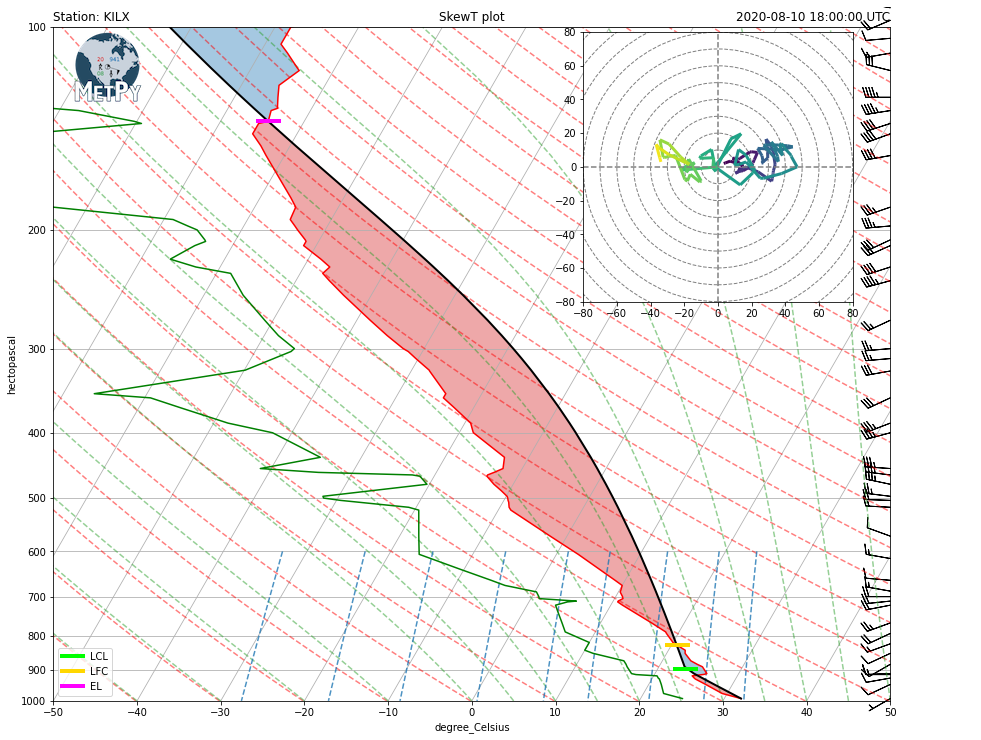

In [26]:
#plot sounding
fig = plt.figure(figsize=(15, 15))

skew = SkewT(fig)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')

# Plot barbs skipping to every other barb
skew.plot_barbs(p[::2], u[::2], v[::2], y_clip_radius=0.03)

# Set sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-50, 50)

# Plot the skew-T parcel temperature profile
skew.plot(p, prof, 'k', linewidth=2)

# Plot a line marker at the LCL/LFC/EL level
skew.plot(lcl_pressure, lcl_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='lime', label='LCL')
skew.plot(lfc_pressure, lfc_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='gold', label='LFC')
skew.plot(el_pressure, el_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='magenta', label='EL')



# Add the relevant special lines
skew.plot_dry_adiabats(t0=np.arange(233,555,10)*units.K)
skew.plot_moist_adiabats(color='tab:green')
skew.plot_mixing_lines(color='tab:blue')

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof)
skew.shade_cape(p, T, prof)

# Plot titles
plt.title('Station: K{}'.format(station), loc='left')
plt.title('SkewT plot', loc='center')
plt.title('{} UTC'.format(date), loc='right')


plt.legend(loc='lower left')
add_metpy_logo(fig, 70, 635)

# Create a hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=10)
h.plot_colormapped(u, v, height)

# Show the plot
plt.show()


In [29]:
#print out variables
print(f'Surface based CAPE: {cape}')
print(f'Surface based CIN: {cin}')
print()
print(f'MU based CAPE: {MU_cape}')
print(f'MU based CIN: {MU_cin}')
print()
print(f'ML based CAPE: {ML_cape}')
print(f'ML based CIN: {ML_cin}')
print()
print(f'Lifted Index: {li}')
print(f'Total Totals: {tt}')
print(f'Precipitable water: {pwat}')
print(f'0-3km SRH: {pos_SRH}')
print(f'EHI: {EHI}')
print()

if(((cape.m>=1500) and (li<=-2) and (cin.m>=-100) and (pos_SRH.m>=100) or (EHI>=1))):
   print('Severe weather possible')
else:
   print('Severe weather not likley')

Surface based CAPE: 4949.237564248017 joule / kilogram
Surface based CIN: -12.32156549160576 joule / kilogram

MU based CAPE: 4949.237564248017 joule / kilogram
MU based CIN: -13.197050453313604 joule / kilogram

ML based CAPE: 2494.2165737679634 joule / kilogram
ML based CIN: -147.095602775765 joule / kilogram

Lifted Index: -12.59771757629353
Total Totals: 52.8
Precipitable water: 1.5837063818571813 inch
0-3km SRH: 117.779485637543 meter ** 2 / second ** 2
EHI: 3.643241591344611

Severe weather possible
